# Simple Regression Model
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [5]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

#### Get AGIS endpoints (RSEs) and site names

In [6]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Reading fts data for one day - all links

In [7]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_TIME'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-01-31', 'fts_2017-02-01', 'fts_2017-02-02', 'fts_2017-02-03', 'fts_2017-02-04', 'fts_2017-02-05', 'fts_2017-02-06', 'fts_2017-02-07', 'fts_2017-02-08']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
Reading took 2474.8673107624054 seconds.


### reading link aggregate data

In [208]:
index_list = []
for i in range(0, DELTA+1):
    index_name= 'fts-aggregates_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%-m')
    if index_name not in index_list:
        index_list.append(index_name)
indexes = ','.join(index_list)
print (index_list)

period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["src", "dest", "timestamp","rate"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "src" : "CERN-PROD" }},
                {"term" : { "dest" : "BNL-ATLAS" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    if not count%10000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        rates.append([r['src']+'__'+r['dest'],r['timestamp']/1000,r['rate']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print(count)
print('Reading took',time.time() - st,'seconds.')
rates = pd.DataFrame(rates, columns=['LINK', 'TS', 'RATE'], index=tsindex)

['fts-aggregates_2017-2']
0
10000
14400
Reading took 0.37066054344177246 seconds.


#### reading endpoing aggregate data

In [209]:
print("from:", period_start, "\t\tuntil:",period_end)
transfer_query = {
    "size": 0,
    "_source": ["incoming", "outcoming", "timestamp","name","egress","ingress"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "name" : "CERN-PROD" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
EPrates = []
tsindex = []
for res in scroll:
    r = res['_source']
    count += 1
    if not count%10000 : print (count)
    EPrates.append([r['ingress'],r['egress'],r['timestamp']/1000])
    tsindex.append(r['timestamp']/1000)
print(count)

print('Reading took',time.time() - st,'seconds.')
EPrates = pd.DataFrame(rates, columns=['ingress','egress', 'TS'], index=tsindex)


from: 2017-02-01 00:00:00 		until: 2017-02-11 00:00:00
10000
14400
Reading took 0.37427377700805664 seconds.


In [9]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
cut = data.where(data.LINK == src+'__'+dst+'__'+act).dropna()
link_rate = []
for t in cut.itertuples():
    t_index = (t.STARTED - (t.STARTED%60))-60  # link rate at the previous minute
    #print (rates.iloc(t_index))
    link_rate.append(rates.loc[t_index].RATE)
cut['LINK_RATE'] = link_rate
    

### making the fit SIZE based

In [19]:
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression()
reg4 = LinearRegression()
cut['SIZE_MB'] = cut.SIZE/(1024*1024)
limit = 250
below_limit = cut.where(cut.SIZE_MB < limit).dropna()
above_limit = cut.where(cut.SIZE_MB >= limit).dropna()
#f = reg.fit(cut[['SIZE_MB', 'LINK_RATE']],cut.N_TIME/(1024*1024))
fit_belowlimit_fi = reg1.fit(below_limit[['SIZE_MB']],below_limit.N_TIME/(1024*1024))
fit_abovelimit_fi = reg2.fit(above_limit[['SIZE_MB']],above_limit.N_TIME/(1024*1024))
fit_belowlimit = reg3.fit(below_limit[['SIZE_MB']],below_limit.N_TIME/(1024*1024))
fit_abovelimit = reg4.fit(above_limit[['SIZE_MB']],above_limit.N_TIME/(1024*1024))
#cut['N_PRED'] = f.predict(cut[['SIZE_MB','LINK_RATE']])
below_limit['N_PRED_FI'] = fit_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_PRED_FI'] = fit_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_PRED'] = fit_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_PRED'] = fit_abovelimit.predict(above_limit[['SIZE_MB']])
cut = below_limit.append(above_limit)

### plotting the fit

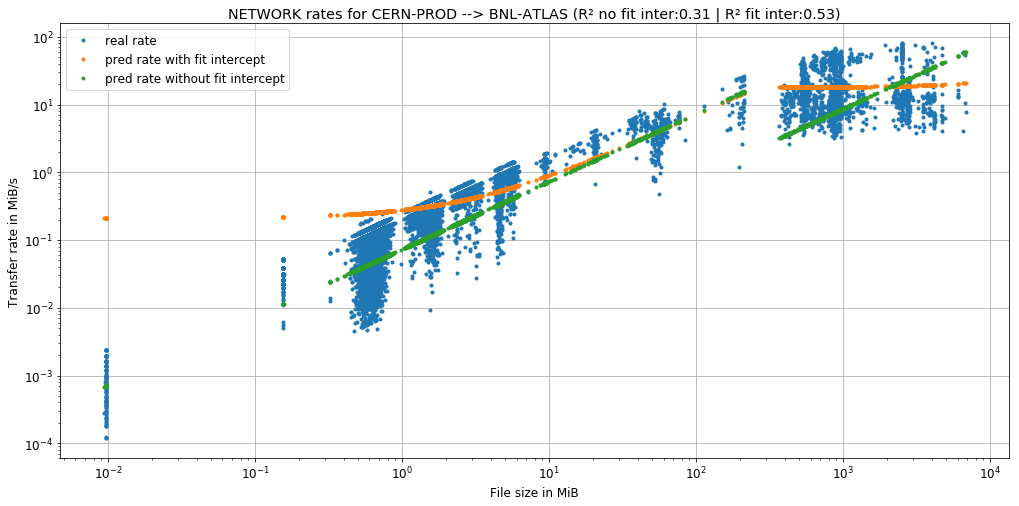

In [42]:
x = np.linspace(int(data.STARTED.min()), int(data.ENDED.min()))
plt.plot(cut[['SIZE_MB']],cut.N_TIME/(1024*1024),'.', label='real rate')
plt.plot(cut.SIZE_MB, cut.N_PRED,'.', label='pred rate with fit intercept')
plt.plot(cut.SIZE_MB, cut.N_PRED_FI,'.', label='pred rate without fit intercept')
n_mae_fi = mae(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_mse_fi = mse(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_r2_fi = r2(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_mae = mae(cut.N_TIME/(1024*1024), cut.N_PRED)
n_mse = mse(cut.N_TIME/(1024*1024), cut.N_PRED)
n_r2 = r2(cut.N_TIME/(1024*1024), cut.N_PRED)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (R² no fit inter:%0.02f | R² fit inter:%0.02f)'%(n_r2_fi,n_r2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('File size in MiB')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

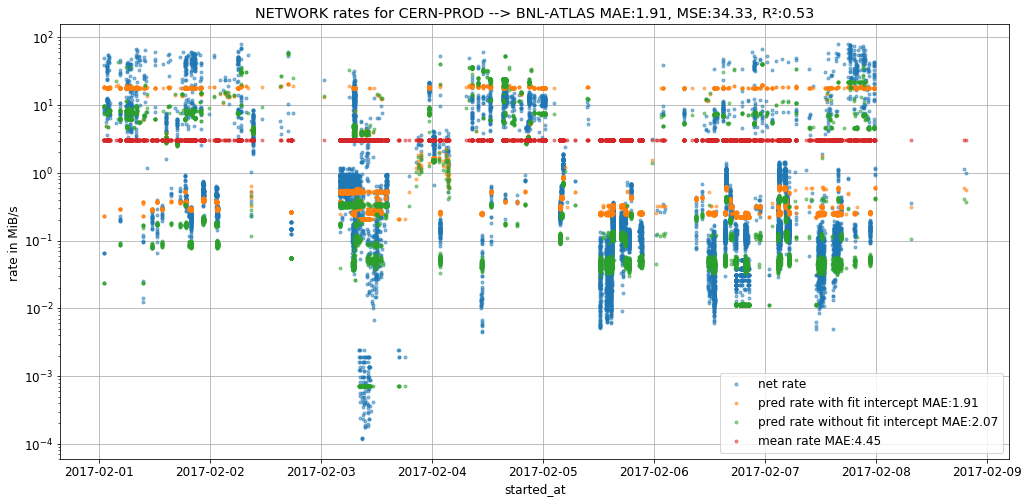

In [49]:
## NET TIMES
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
n_mae = mae(cut.N_TIME/(1024*1024), cut.N_PRED)
n_mse = mse(cut.N_TIME/(1024*1024), cut.N_PRED)
n_r2 = r2(cut.N_TIME/(1024*1024), cut.N_PRED)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
#plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')
plt.plot(cut.index, cut.N_TIME/(1024*1024),'.', alpha=0.5, label='net rate')
plt.plot(cut.index, cut.N_PRED,'.', alpha=0.5, label='pred rate with fit intercept MAE:%.02f'%mae(cut.N_TIME/(1024*1024),cut.N_PRED))
plt.plot(cut.index, cut.N_PRED_FI,'.', alpha=0.5, label='pred rate without fit intercept MAE:%.02f'%mae(cut.N_TIME/(1024*1024),cut.N_PRED_FI))
plt.plot(cut.index, [(cut.N_TIME/(1024*1024)).mean()]*len(cut),'.', alpha=0.5, label='mean rate MAE:%.02f'%mae(cut.N_TIME/(1024*1024),[(cut.N_TIME/(1024*1024)).mean()]*len(cut)))

#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('started_at')
plt.ylabel('rate in MiB/s ')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

### Making the fit LINK RATE based

In [51]:
# reg1 = LinearRegression(fit_intercept=False)
# reg2 = LinearRegression(fit_intercept=False)
# reg3 = LinearRegression()
# reg4 = LinearRegression()

limit = 1
below_limit = cut.where(cut.LINK_RATE < limit).dropna()
above_limit = cut.where(cut.LINK_RATE >= limit).dropna()
# fit_belowlimit_fi = reg1.fit(below_limit[['LINK_RATE']],below_limit.N_TIME/(1024*1024))
# fit_abovelimit_fi = reg2.fit(above_limit[['LINK_RATE']],above_limit.N_TIME/(1024*1024))
# fit_belowlimit = reg3.fit(below_limit[['LINK_RATE']],below_limit.N_TIME/(1024*1024))
# fit_abovelimit = reg4.fit(above_limit[['LINK_RATE']],above_limit.N_TIME/(1024*1024))

below_limit['N_PRED_FI'] = fit_belowlimit_fi.predict(below_limit[['LINK_RATE']])
above_limit['N_PRED_FI'] = fit_abovelimit_fi.predict(above_limit[['LINK_RATE']])
below_limit['N_PRED'] = fit_belowlimit.predict(below_limit[['LINK_RATE']])
above_limit['N_PRED'] = fit_abovelimit.predict(above_limit[['LINK_RATE']])
cut = below_limit.append(above_limit)
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))

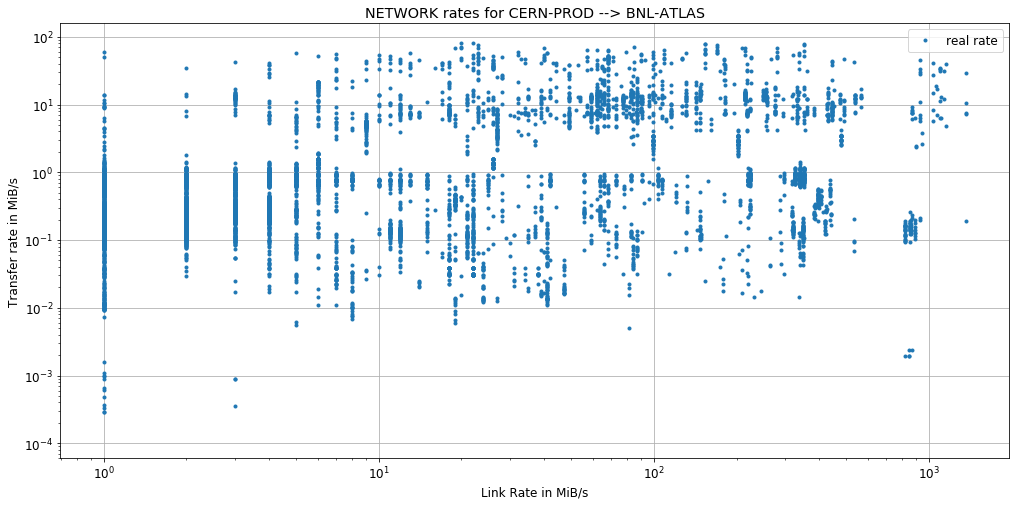

In [195]:
x = np.linspace(int(data.STARTED.min()), int(data.ENDED.min()))
plt.plot(cut[['LINK_RATE']],cut.N_TIME/(1024*1024),'.', label='real rate')

# n_mae_fi = mae(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
# n_mse_fi = mse(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
# n_r2_fi = r2(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
# n_mae = mae(cut.N_TIME/(1024*1024), cut.N_PRED)
# n_mse = mse(cut.N_TIME/(1024*1024), cut.N_PRED)
# n_r2 = r2(cut.N_TIME/(1024*1024), cut.N_PRED)
# plt.plot(cut.LINK_RATE, cut.N_PRED,'.', label='pred rate with fit intercept R²:%.02f'%n_r2)
# plt.plot(cut.LINK_RATE, cut.N_PRED_FI,'.', label='pred rate without fit interceptR²:%.02f'%n_r2_fi)

#plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
#plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (R² fit inter:%0.02f | R² no fit inter:%0.02f)'%(n_r2_fi,n_r2))

plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Link Rate in MiB/s')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

### Making fit based on SIZE,LINK_RATE, cutting on size

In [63]:
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression()
reg4 = LinearRegression()
cut['SIZE_MB'] = cut.SIZE/(1024*1024)
limit = 150
below_limit = cut.where(cut.SIZE_MB < limit).dropna()
above_limit = cut.where(cut.SIZE_MB >= limit).dropna()
fit_belowlimit_fi = reg1.fit(below_limit[['SIZE_MB','LINK_RATE']],below_limit.N_TIME/(1024*1024))
fit_abovelimit_fi = reg2.fit(above_limit[['SIZE_MB','LINK_RATE']],above_limit.N_TIME/(1024*1024))
fit_belowlimit = reg3.fit(below_limit[['SIZE_MB','LINK_RATE']],below_limit.N_TIME/(1024*1024))
fit_abovelimit = reg4.fit(above_limit[['SIZE_MB','LINK_RATE']],above_limit.N_TIME/(1024*1024))
#cut['N_PRED'] = f.predict(cut[['LINK_RATE']])
below_limit['N_PRED_FI'] = fit_belowlimit_fi.predict(below_limit[['SIZE_MB','LINK_RATE']])
above_limit['N_PRED_FI'] = fit_abovelimit_fi.predict(above_limit[['SIZE_MB','LINK_RATE']])
below_limit['N_PRED'] = fit_belowlimit.predict(below_limit[['SIZE_MB','LINK_RATE']])
above_limit['N_PRED'] = fit_abovelimit.predict(above_limit[['SIZE_MB','LINK_RATE']])
cut = below_limit.append(above_limit)

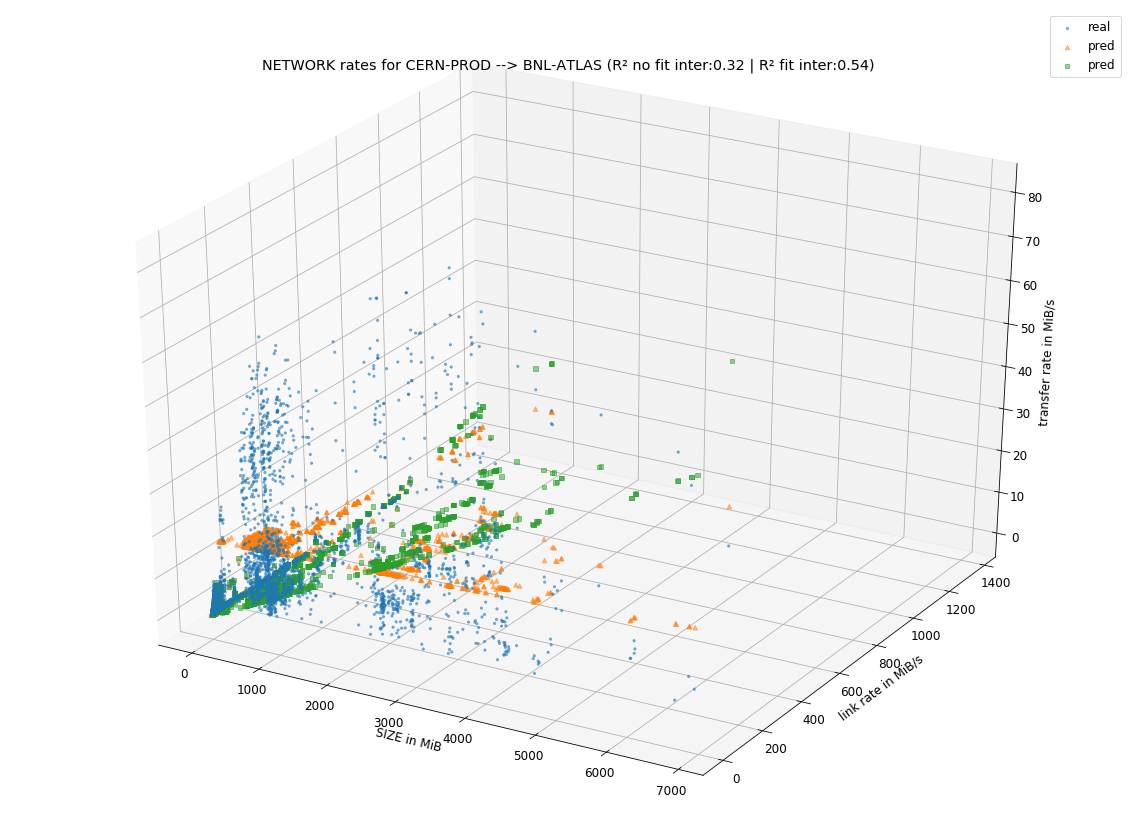

In [79]:

fplot = plt.figure().gca(projection='3d')
#plt.plot(cut[['SIZE_MB']],cut.N_TIME/(1024*1024),'.', label='real rate')
#plt.plot(cut[['SIZE_MB']],cut.LINK_RATE,'.', label='real rate')
fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_TIME/(1024*1024),marker='.',alpha=0.5, label='real')
fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED,marker='^',alpha=0.5, label='pred')
fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED_FI,marker='s',alpha=0.5, label='pred')
fplot.set_xlabel('SIZE in MiB')
fplot.set_ylabel('link rate in MiB/s')
fplot.set_zlabel('transfer rate in MiB/s')
#fplot.set_xscale('log')
#fplot.set_yscale('log')
#fplot.set_zscale('log')
#plt.plot(cut[['SIZE_MB']],cut.N_TIME/(1024*1024),cut.N_PRED_FI,zdir='z',fmt='.', label='pred rate with fit intercept',alpha=0.5)

n_mae_fi = mae(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_mse_fi = mse(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_r2_fi = r2(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
n_mae = mae(cut.N_TIME/(1024*1024), cut.N_PRED)
n_mse = mse(cut.N_TIME/(1024*1024), cut.N_PRED)
n_r2 = r2(cut.N_TIME/(1024*1024), cut.N_PRED)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (R² no fit inter:%0.02f | R² fit inter:%0.02f)'%(n_r2_fi,n_r2))
#plt.yscale('log')
#plt.xscale('log')
#plt.xlabel('File size in MiB')
#plt.ylabel('Transfer rate in MiB/s')
fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.legend()
#plt.grid()
plt.show()

# Non Linear Fit
rate[bytes/s] = size[bytes] / ( size [bytes]/constant1[bytes/s] + constant2[s]) limited to constant3[bytes/s]

where: 

constant3 is the limit on the transfer rate imposed by the disc read/write,

constant2 is the overhead time (time to establish connection, authenticate etc.),

constant1 is the rate

In [185]:

def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model
    

In [190]:

vars = [cut.N_TIME.mean(), .1, 100.0]
out = leastsq(objective, vars, args=(cut.SIZE, cut.N_TIME))

In [191]:
print(out)
rate = out[0][0]
overhead = out[0][1]
diskrw = out[0][2]

cut['NLFIT'] = cut.SIZE/((cut.SIZE/rate)+overhead)
cut['NLFIT'][cut['NLFIT']>diskrw]=diskrw

(array([  2.38768452e+07,   8.62096799e+00,   2.03600228e+07]), 1)


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAE:1.85 R²:0.54


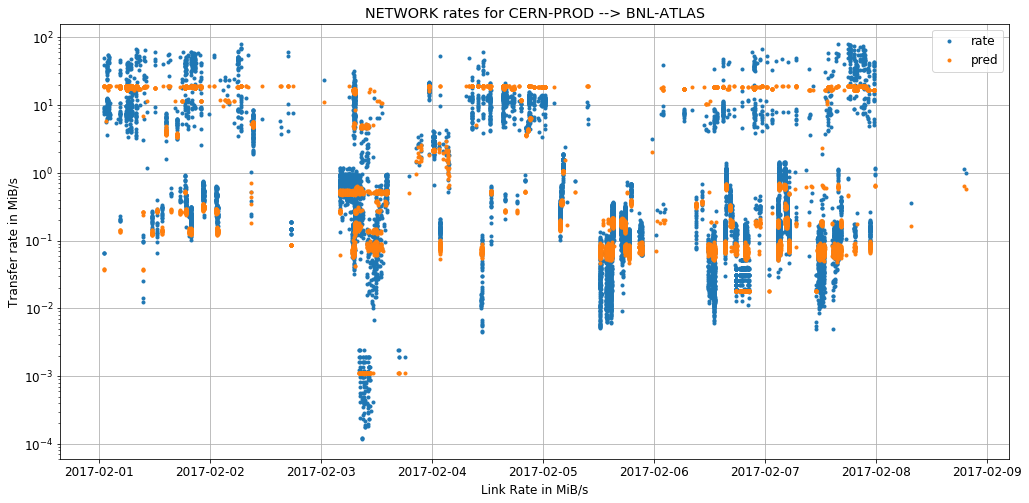

In [192]:
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
plt.plot(cut.index, cut.N_TIME/(1024*1024),'.', label='rate')
plt.plot(cut.index, cut.NLFIT/(1024*1024),'.', label='pred')
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Link Rate in MiB/s')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()


MAE:1.85 R²:0.54


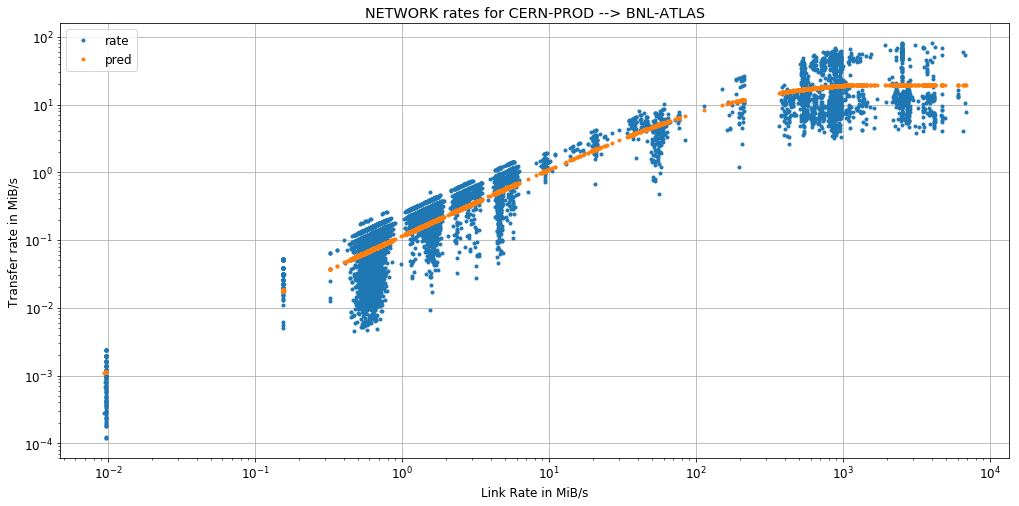

In [193]:
plt.plot(cut.SIZE_MB, cut.N_TIME/(1024*1024),'.', label='rate')
plt.plot(cut.SIZE_MB, cut.NLFIT/(1024*1024),'.', label='pred')
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Link Rate in MiB/s')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()